In [1]:
# Import dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


torch.float32
torch.int64
torch.float32


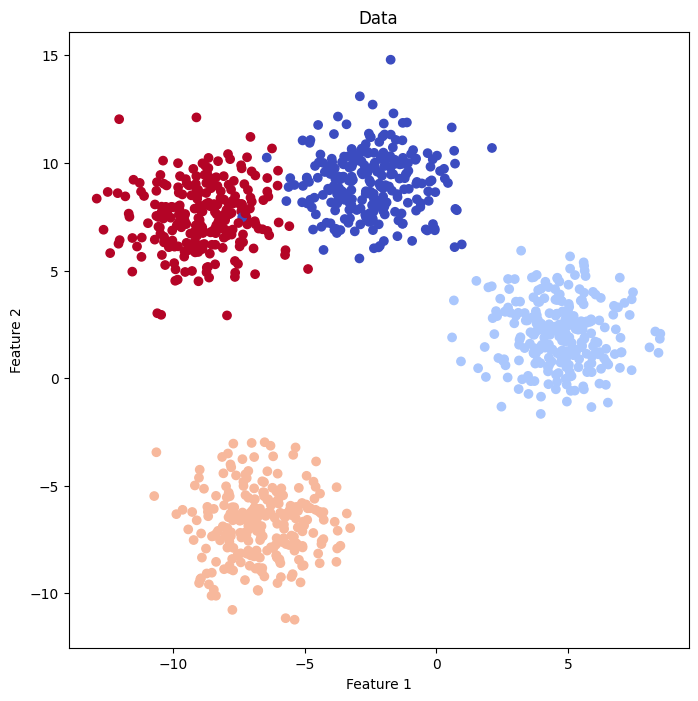

In [2]:
# Create dataset
NUM_ClASSES = 4
NUM_FEATURES = 2
NUM_SAMPLES = 1000
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=NUM_SAMPLES,
                  centers=NUM_ClASSES,
                  n_features=NUM_FEATURES,
                  cluster_std=1.5,
                  random_state=RANDOM_SEED)

# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

print(X_blob.dtype)
print(y_blob.dtype)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)
print(X_train.dtype)
# Plot data

plt.figure(figsize=(8, 8))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap='coolwarm')
plt.title('Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()




In [3]:
# first lets define some commonaly used functions
# Set up device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

def print_shape_device(*args):
    """
    This function prints the shape, data type and device of the given tensors or numpy arrays.

    Parameters:
    *args (torch tensor or numpy array): Variable length argument list of tensors or arrays.

    Returns:
    None
    """
    for arg in args:
        if torch.is_tensor(arg):
            print(f"Shape: {arg.shape} | Device: {arg.device}| Type : {arg.dtype} | torch tensor")
        elif isinstance(arg, np.ndarray):
            print(f"Shape: {arg.shape} | Device: CPU | Type : {arg.dtype} | numpy array")
        else:
            print("Input type not supported. Please provide a torch tensor or a numpy array.")

def change_device(device='cpu', *args):
    """
    This function changes the device of the data to the device specified.

    Parameters:
    device (str): The device to which the data should be moved.
    *args (torch tensor or nn.Module): Variable length argument list of tensors or models to be moved.

    Returns:
    result (tuple): A tuple containing the tensors or models moved to the specified device.
    """
    result = []
    for arg in args:
        moved_arg = arg.to(device)
        print(f"Moved {type(arg).__name__} to {device}")
        result.append(moved_arg)
    return tuple(result)

def plot_scatter(X_train, y_train, X_test = None, y_test = None, title = "Plot"):
    """
    This function plots the training and test data in a scatter plot.
    If it is desired to plot the training and test data in the same plot, the test data can be passed along.
    If it is desired to plot the training and test data set in different plots, the test data can be omitted.
    and the function can be called again with the test data as the training data.

    Parameters:
    X_train (numpy array): The training data features.
    y_train (numpy array): The training data labels.
    X_test (numpy array): The test data features. (optional)
    y_test (numpy array): The test data labels. (optional)
    title (str): The title of the plot.

    Returns:
    None
    """

    #check if arguments are numpy arrays
    if not isinstance(X_train, np.ndarray) or not isinstance(y_train, np.ndarray):
        #change device to cpu then to numpy arrays
        _is_tensor = True
        X_train = X_train.to('cpu').detach().numpy()
        y_train = y_train.to('cpu').detach().numpy()

    # Create a new figure with a specific size
    plt.figure(figsize=(8, 4))

    # Create a scatter plot of the training data.
    # The colors of the points are determined by their labels (y_train).
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdYlBu)

    # Create a scatter plot of the test data.
    # The colors of the points are determined by their labels (y_test).
    # This is only done if X_test and y_test are not None.
    if X_test is not None and y_test is not None:
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm , edgecolors='y', alpha=0.6)

    # Set the title of the plot
    plt.title(title)

    # Set the labels of the x and y axes
    plt.xlabel('X0')
    plt.ylabel('X1')

    # Display legend
    plt.legend(['Class 0', 'Class 1', 'Class 2', 'Class 3'])

    # Display the plot
    plt.show()

def raw_to_class_specfic(raw):
    """
    This function converts the raw output of the model to class specific probabilities.

    Parameters:
    raw (torch tensor): The raw output of the model.

    Returns:
    class (torch tensor): The probable class of the input.
    """
    raw = torch.softmax(raw, dim=1)
    probab_class = torch.argmax(raw, dim=1)
    return probab_class

# Calculate accuracy
def accuracy_fn(preds, y, device = 'cuda'):
    """
    This function calculates the accuracy of the model's predictions.

    Parameters:
    preds (torch tensor or numpy array): The model predictions.
    y (torch tensor or numpy array): The actual labels.
    device (torch.device): The device to perform calculations on.

    Returns:
    accuracy (float): The accuracy of the model's predictions.
    """
    # # Save the original state of the inputs
    # preds_orig = preds
    # y_orig = y

    # # Check the device and data type of the inputs
    # if not torch.is_tensor(preds):
    #     preds = torch.from_numpy(preds).to(device)

    # if not torch.is_tensor(y):
    #     y = torch.from_numpy(y).to(device)


    # # print_shape_device(preds, y)
    # This is a function that will be called multiple times so avoid doint his kind
    # of computation that needs to be done only once in begining and end in a function

    # Calculate the number of correctly classified samples
    correct = torch.eq(preds, y).sum().item()

    # Calculate the total number of samples
    total = y.shape[0]

    # Calculate the accuracy
    accuracy = correct / total

    # Convert the inputs back to their original state
    if isinstance(preds, np.ndarray):
        preds = preds.cpu().numpy()
    if isinstance(y, np.ndarray):
        y = y.cpu().numpy()

    # Return the accuracy
    return accuracy

# make a function to plot the decision boundary
def plot_decision_boundary_mine(X, y, model, title='Decision Boundary'):
    # Create a meshgrid for our plot
    h = .02  # step size in the mesh

    X = X.cpu().numpy()
    y = y.cpu().numpy()

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

     # Convert to torch tensor and move to the correct device
    if isinstance(xx, np.ndarray):
        xx = torch.from_numpy(xx).to(device)
        xx = xx.type(torch.float32)
    if isinstance(yy, np.ndarray):
        yy = torch.from_numpy(yy).to(device)
        yy = yy.type(torch.LongTensor)

    # Use the model to make predictions
    print_shape_device(xx, yy)
    with torch.inference_mode():
        yy.type(torch.LongTensor)
        Z = model(torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))
        Z = raw_to_class_specfic(Z)

    Z = Z.reshape(xx.shape)

    # Move Z back to CPU and convert to numpy for plotting
    Z = Z.cpu().numpy()

    # Plot the contour and training examples
    plt.contourf(xx.cpu().numpy(), yy.cpu().numpy(), Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40)
    plt.title(title)
    plt.show()


Using cuda device


In [4]:
print_shape_device(X_train, y_train, X_test, y_test)
X_train, y_train, X_test, y_test = change_device(device, X_train, y_train, X_test, y_test)

Shape: torch.Size([800, 2]) | Device: cpu| Type : torch.float32 | torch tensor
Shape: torch.Size([800]) | Device: cpu| Type : torch.int64 | torch tensor
Shape: torch.Size([200, 2]) | Device: cpu| Type : torch.float32 | torch tensor
Shape: torch.Size([200]) | Device: cpu| Type : torch.int64 | torch tensor
Moved Tensor to cuda
Moved Tensor to cuda
Moved Tensor to cuda
Moved Tensor to cuda


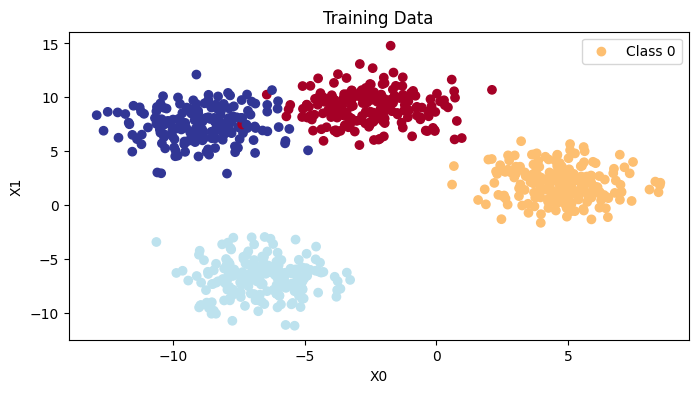

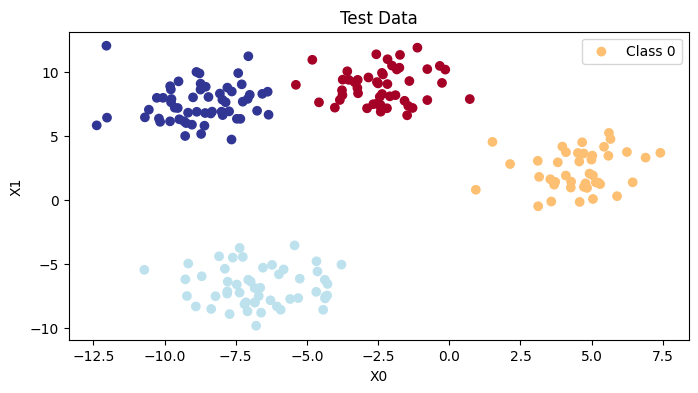

In [5]:

plot_scatter(X_train, y_train, title = "Training Data")
plot_scatter(X_test, y_test, title = "Test Data")

In [6]:
print_shape_device(X_train, y_train, X_test, y_test)

Shape: torch.Size([800, 2]) | Device: cuda:0| Type : torch.float32 | torch tensor
Shape: torch.Size([800]) | Device: cuda:0| Type : torch.int64 | torch tensor
Shape: torch.Size([200, 2]) | Device: cuda:0| Type : torch.float32 | torch tensor
Shape: torch.Size([200]) | Device: cuda:0| Type : torch.int64 | torch tensor


In [7]:

class mc_classification(nn.Module):
    def __init__(self, num_features: int, num_classes: int, hidden_size: int = 32):
        """
        This function initializes the model.

        Parameters:
        num_features (int): The number of input features
        num_classes (int): The number of output classes

        """
        super(mc_classification, self).__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = num_features, out_features= hidden_size),
            nn.Linear(in_features = hidden_size, out_features= hidden_size),
            nn.Linear(in_features = hidden_size, out_features= hidden_size),
            nn.Linear(in_features = hidden_size, out_features= num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines the computation performed at every call.

        Parameters:
        x (torch.Tensor): The input tensor

        Returns:
        torch.Tensor: The output tensor
        """
        return self.linear_layer_stack(x)

In [8]:
# create loss function and optimizer

model = mc_classification(NUM_FEATURES, NUM_ClASSES)
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [9]:
# Untrained model output

with torch.inference_mode():
    print_shape_device(X_train, y_train, X_test, y_test)
    y_pred = model(X_train)
    y_pred= torch.softmax(y_pred, dim=1)
    print_shape_device(y_pred)

y_pred_class = raw_to_class_specfic(y_pred)
print(y_pred)
print_shape_device(y_pred_class)
y_pred_class

Shape: torch.Size([800, 2]) | Device: cuda:0| Type : torch.float32 | torch tensor
Shape: torch.Size([800]) | Device: cuda:0| Type : torch.int64 | torch tensor
Shape: torch.Size([200, 2]) | Device: cuda:0| Type : torch.float32 | torch tensor
Shape: torch.Size([200]) | Device: cuda:0| Type : torch.int64 | torch tensor
Shape: torch.Size([800, 4]) | Device: cuda:0| Type : torch.float32 | torch tensor
tensor([[0.2335, 0.3877, 0.2374, 0.1413],
        [0.5115, 0.2260, 0.1815, 0.0810],
        [0.3516, 0.0375, 0.2129, 0.3980],
        ...,
        [0.4840, 0.2535, 0.1834, 0.0790],
        [0.3597, 0.0546, 0.2275, 0.3582],
        [0.6330, 0.0775, 0.1679, 0.1215]], device='cuda:0')
Shape: torch.Size([800]) | Device: cuda:0| Type : torch.int64 | torch tensor


tensor([1, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 3, 1, 1, 0, 0, 3, 0, 0, 1,
        0, 3, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 3, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 3, 0, 0, 1, 0, 3, 1, 0, 3, 3, 3, 1, 0, 0,
        0, 1, 1, 1, 3, 0, 0, 1, 3, 0, 1, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
        0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 3,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        3, 0, 3, 0, 0, 1, 1, 0, 1, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 1, 1, 3, 0, 0,
        3, 0, 3, 0, 0, 0, 0, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 3, 0, 0, 0, 0, 3,
        0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 1, 3, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 3, 0, 3, 0, 1, 0, 3, 0, 0, 0,

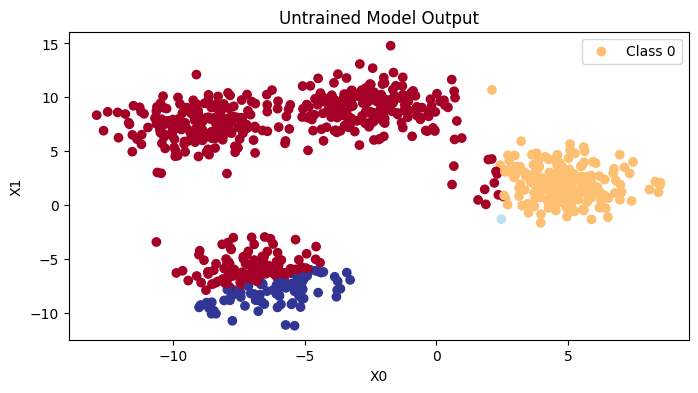

In [10]:
plot_scatter(X_train, y_pred_class, title = "Untrained Model Output")

### Training Loop

In [11]:
# Set up seeds
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Set no of epochs
NUM_EPOCHS = 100

# Change data to tensor and move to device
print_shape_device(X_train, y_train, X_test, y_test)
# if data is in np array convert it to tensor
if not torch.is_tensor(X_train):
    X_train = torch.from_numpy(X_train).type(torch.float32)
    y_train = torch.from_numpy(y_train).type(torch.float32)
    X_test = torch.from_numpy(X_test).type(torch.float32)
    y_test = torch.from_numpy(y_test).type(torch.float32)
    X_train, y_train, X_test, y_test = change_device(device, X_train, y_train, X_test, y_test)

print_shape_device(X_train, y_train, X_test, y_test)

Shape: torch.Size([800, 2]) | Device: cuda:0| Type : torch.float32 | torch tensor
Shape: torch.Size([800]) | Device: cuda:0| Type : torch.int64 | torch tensor
Shape: torch.Size([200, 2]) | Device: cuda:0| Type : torch.float32 | torch tensor
Shape: torch.Size([200]) | Device: cuda:0| Type : torch.int64 | torch tensor
Shape: torch.Size([800, 2]) | Device: cuda:0| Type : torch.float32 | torch tensor
Shape: torch.Size([800]) | Device: cuda:0| Type : torch.int64 | torch tensor
Shape: torch.Size([200, 2]) | Device: cuda:0| Type : torch.float32 | torch tensor
Shape: torch.Size([200]) | Device: cuda:0| Type : torch.int64 | torch tensor


In [12]:
def train_model(model : mc_classification, loss_fn, optimizer, X_train, y_train, X_test, y_test, epochs=100):
    """
    Train a PyTorch model with the given parameters.

    Args:
        model (nn.Module): The PyTorch model to train.
        loss_fn (nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        X_train (torch.Tensor): The training data.
        y_train (torch.Tensor): The training labels.
        X_test (torch.Tensor): The testing data.
        y_test (torch.Tensor): The testing labels.
        epochs (int, optional): The number of epochs to train for. Defaults to 1000.

    Returns:
        dict: A dictionary containing the trained model and the loss values for each epoch.
        {
            model: .
            loss_values: .
            test_loss_values: .
        }
    """
    # Step 1: Set the seed for generating random numbers
    torch.manual_seed(42)

    # Step 2: Initialize lists to store epoch count, loss values, and test loss values
    epoch_count = []
    loss_values = []
    accuracy_values = []
    test_loss_values = []

    # Step 3: Training loop
    for epoch in range(epochs):
        # Step 4: Set the model to training mode
        model.train()
        epoch_count.append(epoch)

        # Step 5: Forward pass - compute predicted y by passing x to the model
        y_pred = model(X_train)

        # Step 6: Compute loss
        loss = loss_fn(y_pred, y_train)
        loss_values.append(loss.item())

        # Step 7: Zero all of the gradients for the variables
        optimizer.zero_grad()

        # Step 8: Backward pass - compute gradient of the loss with respect to model parameters
        loss.backward()

        # Step 9: Update the weights
        optimizer.step()

        # Step 10: Switch model to evaluation mode
        model.eval()

        # Step 11: Disable gradient calculation
        with torch.inference_mode():
            # Step 12: Make predictions on the test set
            y_pred = model(X_test)

            # Step 13: Calculate the loss on the test set
            test_loss = loss_fn(y_pred, y_test)
            y_pred_acc = raw_to_class_specfic(y_pred)
            accuracy_values.append(accuracy_fn(y_pred_acc, y_test))
            test_loss_values.append(test_loss.item())

        # Step 14: Print loss values every 10 epochs
        if(epoch % 10 == 0):
            print(f"Epoch:{epoch} | Loss:{loss.item():.4f} | Test Loss:{test_loss.item():.4f} | Accuracy:{accuracy_fn(y_pred_acc, y_test):.4f}")

    # Plot the training and test losses
    plt.plot(epoch_count, loss_values, 'r--')
    plt.plot(epoch_count, test_loss_values, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.plot(epoch_count, accuracy_values, 'g-')
    plt.legend(['Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    # Step 15: Return the trained model and the loss values for each epoch
    return {'model': model, 'loss_values': loss_values, 'test_loss_values': test_loss_values}


Epoch:0 | Loss:1.3963 | Test Loss:1.1349 | Accuracy:0.6750
Epoch:10 | Loss:0.4639 | Test Loss:0.4320 | Accuracy:0.9850
Epoch:20 | Loss:0.3076 | Test Loss:0.2936 | Accuracy:0.9900
Epoch:30 | Loss:0.2286 | Test Loss:0.2204 | Accuracy:0.9900
Epoch:40 | Loss:0.1812 | Test Loss:0.1751 | Accuracy:0.9900
Epoch:50 | Loss:0.1500 | Test Loss:0.1446 | Accuracy:0.9900
Epoch:60 | Loss:0.1281 | Test Loss:0.1229 | Accuracy:0.9900
Epoch:70 | Loss:0.1121 | Test Loss:0.1068 | Accuracy:0.9900
Epoch:80 | Loss:0.0999 | Test Loss:0.0946 | Accuracy:0.9900
Epoch:90 | Loss:0.0905 | Test Loss:0.0849 | Accuracy:0.9900


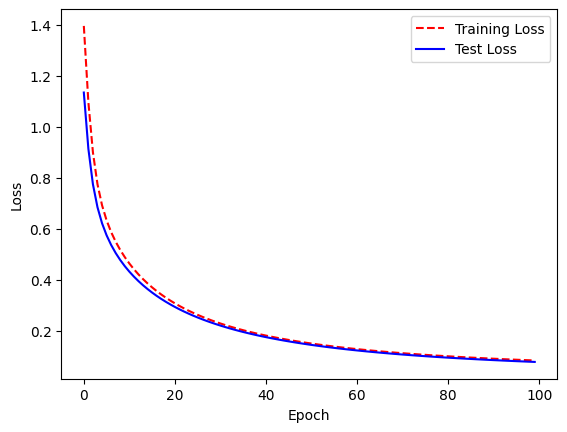

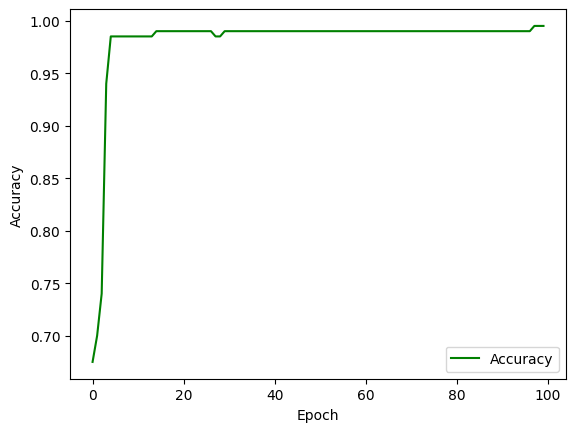

{'model': mc_classification(
   (linear_layer_stack): Sequential(
     (0): Linear(in_features=2, out_features=32, bias=True)
     (1): Linear(in_features=32, out_features=32, bias=True)
     (2): Linear(in_features=32, out_features=32, bias=True)
     (3): Linear(in_features=32, out_features=4, bias=True)
   )
 ),
 'loss_values': [1.3962548971176147,
  1.0966285467147827,
  0.8998615741729736,
  0.7750457525253296,
  0.6926076412200928,
  0.6333469152450562,
  0.5872507095336914,
  0.5493578314781189,
  0.517074704170227,
  0.48891445994377136,
  0.46394675970077515,
  0.4415466785430908,
  0.42127081751823425,
  0.4027904272079468,
  0.3858526647090912,
  0.3702576756477356,
  0.3558433949947357,
  0.3424757421016693,
  0.33004218339920044,
  0.3184468746185303,
  0.3076075315475464,
  0.2974526286125183,
  0.28791987895965576,
  0.27895432710647583,
  0.27050772309303284,
  0.26253703236579895,
  0.2550039291381836,
  0.24787431955337524,
  0.24111734330654144,
  0.23470553755760193

In [13]:

# Train the model
modek = model.to(device)
train_model(model, loss_fn, optimizer, X_train, y_train, X_test, y_test, epochs=NUM_EPOCHS)

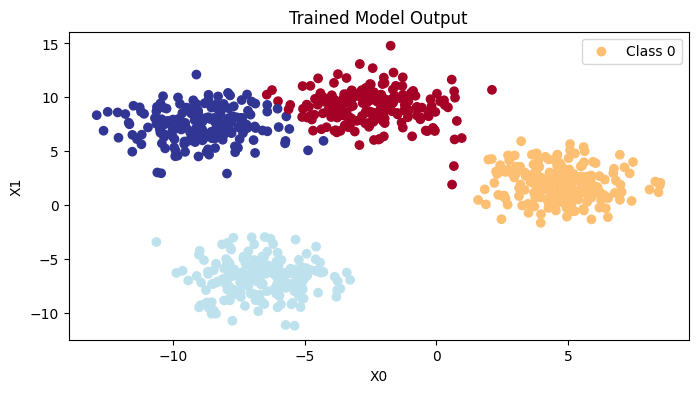

In [14]:

# plot new predictions

with torch.inference_mode():
    y_pred = model(X_train)
    y_pred = torch.softmax(y_pred, dim=1)
    y_pred_class = raw_to_class_specfic(y_pred)

plot_scatter(X_train, y_pred_class, title = "Trained Model Output")

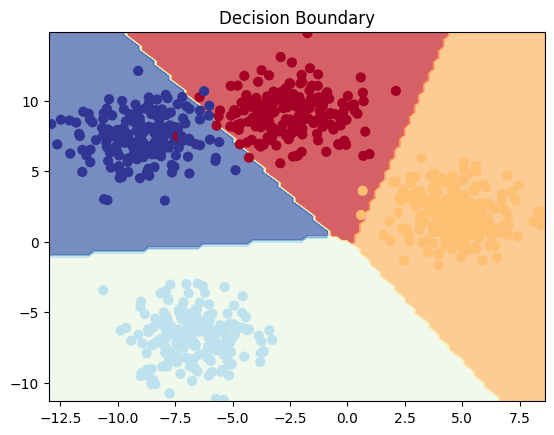

In [15]:
from helper_functions import plot_decision_boundary

plt.title("Decision Boundary")
plot_decision_boundary(model, X_train, y_train)


In [19]:
from torchmetrics import Accuracy, Precision, Recall, F1Score

In [28]:
#Setup metrics

torchmetrics_accuracy = Accuracy('multiclass', num_classes=NUM_ClASSES).to(device)
print_shape_device(y_pred_class, y_train)
torchmetrics_accuracy(y_pred_class, y_train)



Shape: torch.Size([800]) | Device: cuda:0| Type : torch.int64 | torch tensor
Shape: torch.Size([800]) | Device: cuda:0| Type : torch.int64 | torch tensor


tensor(0.9912, device='cuda:0')

In [29]:
torchmetrics_precision = Precision('multiclass', num_classes=NUM_ClASSES).to(device)
torchmetrics_precision(y_pred_class, y_train)

tensor(0.9912, device='cuda:0')

In [31]:
torchmetrics_recall = Recall('multiclass', num_classes=NUM_ClASSES).to(device)
torchmetrics_recall(y_pred_class, y_train)

tensor(0.9912, device='cuda:0')